In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


# Expectation-Maximization (EM) Algorithm Analysis

In [ ]:
def exp_max(Iter, K, pdf, train, Xmat, W_Init, P_Init):
    """
    Performs the Expectation-Maximization algorithm for a Gaussian Mixture Model.

    Args:
        Iter (int): Number of iterations for the EM algorithm.
        K (int): Number of clusters.
        pdf (function): Probability density function (e.g normal_pdf) to compute probabilities.
        train (function): A function to update parameters (e.g., normal_train for means).
        Xmat (np.ndarray): The training data, with shape (n, D), where n is samples and D is features.
        W_Init (np.ndarray): The initial weights for each cluster.
        P_Init (np.ndarray): The initial parameters (means) for each cluster.

    Returns:
       tuple: A tuple containing the final weights (W), parameters (P), and cluster probabilities (p).
    
    """
    n, D = Xmat.shape

    # p will store the "responsibility" of each cluster k for each data point n
    p = np.zeros((K, n))
    W, P = W_Init, P_Init
    for i in range(0,Iter):
        # E-Step : Calculate the expectation of the latent variables
        # We calculate the probability of each data point belonging to each cluster,
        # given our current model parameters (W and P). This is the 'soft' assignment.

        for k in range(0,K):
            # Calculate the likelihood of the data under Gaussian k, scaled by the cluster's weight.
            p[k,:] = W[0,k]*pdf(P[:,k],Xmat)

        # M-Step : maximize the likelihood function
        # We re-estimate the model parameters (W and P) using the calculated responsibilities
        # to find parameters that maximize the expected log-likelihood.
        
        # Normalize the probabilities to get responsibilities. The sum of responsibilities
        # for each data point across all clusters is 1.

              
        p = (p/sum(p,0))

        # Re-calculate the mixture weights (W) as the mean responsibility for each cluster. 
        W = np.mean(p,1).reshape(1,3)

        # Re-calculate the parameters (means) for each cluster.
        for k in range(0,K):
            P[:,k] = train(p[k,:],Xmat)
    return W, P, p

def normal_train(p, Xmat):
    """Updates the mean of a Gaussian component based on weighted data points."""
    # The new mean is the weighted average of all data points, where the weights
    # are the responsibilities of the cluster for those points.

    m = (Xmat.T @ p.T)/sum(p)
    return m

def normal_pdf(m, Xmat):
    """Calculates the PDF of a multivariate normal distribution with a fixed variance."""

    var = 1 # Assuming a fixed variance of 1 for simplicity
    C = np.zeros((2,2))
    C[0,0] = var
    C[1,1] = var
    mvn = multivariate_normal(m.T, C )
    return mvn.pdf(Xmat)

# Data Visualization

#### Load the clusterdata.csv file and visualize the data points to understand their underlying structure.

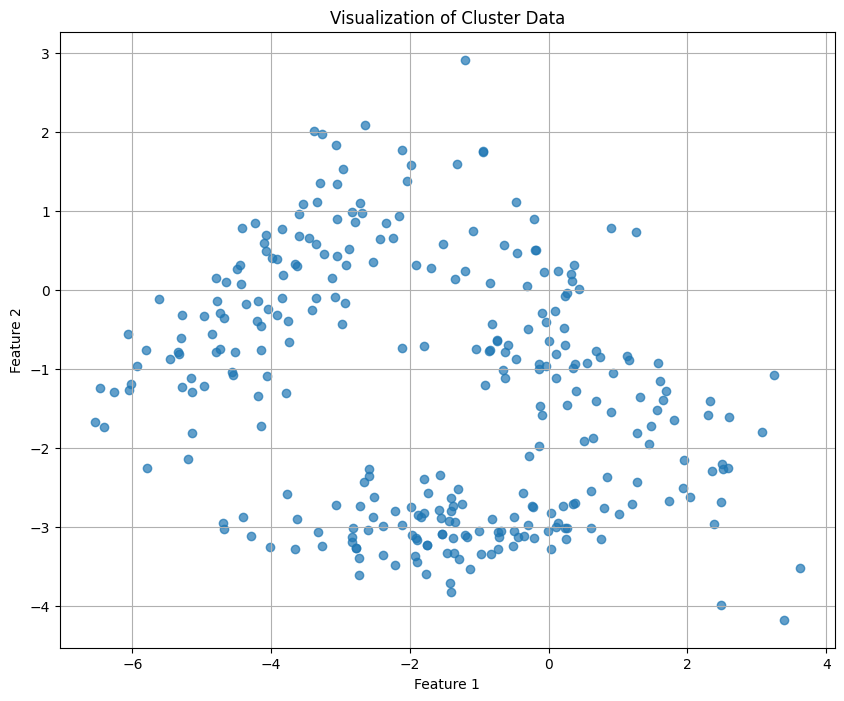

In [36]:
# Load the dataset from the provided file
Xmat = np.genfromtxt('../data/clusterdata.csv', delimiter=',')

# Create a scatter plot to visualize the data
plt.figure(figsize=(10, 8))
plt.scatter(Xmat[:, 0], Xmat[:, 1], alpha=0.7 )
plt.title('Visualization of Cluster Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

#### TEST THE CODE

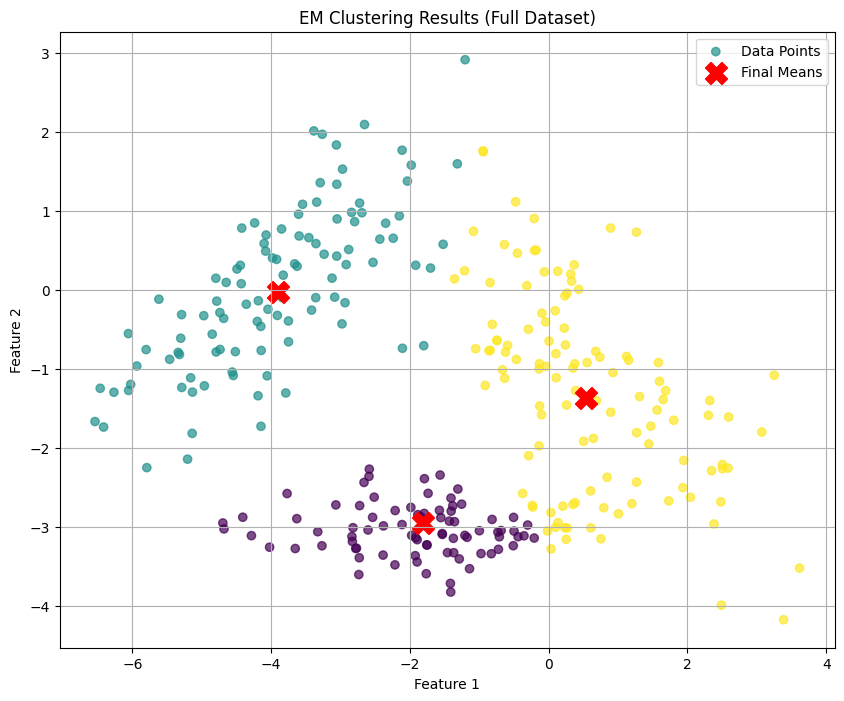

Final Cluster Weights (W): [[0.26703009 0.35791118 0.37505873]]
Final Cluster Means (P):
 [[-1.81723463 -3.90018538  0.53430012]
 [-2.94803675 -0.02989837 -1.36506482]]


In [30]:
W = np.array([[1/3,1/3,1/3]])
M  = np.array([[-2.0,-4,0],[-3,1,-1]])
W_final, P, p = exp_max(100, 3, normal_pdf, normal_train, Xmat, W, M)

labels_em = np.argmax(p, axis=0)

# --- Plotting the Results ---
plt.figure(figsize=(10, 8))
plt.scatter(Xmat[:, 0], Xmat[:, 1], c=labels_em, cmap='viridis', alpha=0.7, label='Data Points')
plt.scatter(P[0, :], P[1, :], s=250, c='red', marker='X', label='Final Means')
plt.title('EM Clustering Results (Full Dataset)')
plt.xlabel('Feature 1'); plt.ylabel('Feature 2'); plt.legend(); plt.grid(True)
plt.show()

print("Final Cluster Weights (W):", W_final)
print("Final Cluster Means (P):\n", P)



#### Train/Test Split

Now, let's see how the model generalizes to new, unseen data by splitting our dataset into a training set (80%) and a testing set (20%).

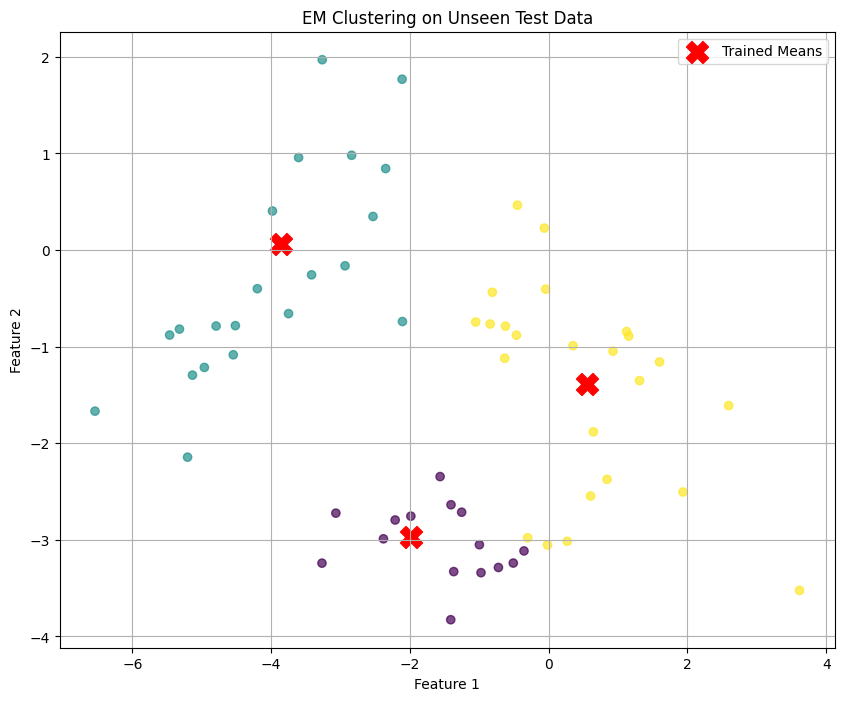

In [31]:
# Create a random permutation of indices

np.random.seed(42) # for reproducible results

# Create a random permutation of indices
indices = np.random.permutation(Xmat.shape[0])
train_idx, test_idx = indices[:240], indices[240:]

# Split the data
X_train, X_test = Xmat[train_idx,:], Xmat[test_idx,:]

# Train the model on the training set
W_trained, P_trained, _ = exp_max(100, 3, normal_pdf, normal_train, X_train, W, M)

# Test the model on the test set
p_test = np.zeros((3, X_test.shape[0]))
for k in range(3):
    p_test[k,:] = W_trained[0,k] * normal_pdf(P_trained[:,k], X_test)
labels_test = np.argmax(p_test, axis=0)

# Plot the test results
plt.figure(figsize=(10, 8))
plt.scatter(X_test[:, 0], X_test[:, 1], c=labels_test, cmap='viridis', alpha=0.7)
plt.scatter(P_trained[0, :], P_trained[1, :], s=250, c='red', marker='X', label='Trained Means')
plt.title('EM Clustering on Unseen Test Data')
plt.xlabel('Feature 1'); plt.ylabel('Feature 2'); plt.legend(); plt.grid(True)
plt.show()

Observation: The test points are clustered perfectly. The means learned from the training data are sufficient to correctly categorize the unseen data points. This indicates the model has generalized well and is not overfitting.

### EM Algorithm Deep Dive & Experiments 🧪

Fixed Variance Assumption: The normal_pdf function assumes a spherical Gaussian with a fixed variance of 1. Looking at the data plot, the clusters are fairly circular, so this is a reasonable simplification. However, a more advanced model would learn a full covariance matrix for each cluster, allowing it to capture elliptical shapes and different orientations, which would be a more accurate representation.

Experimenting with Variance:

Decreasing Variance (e.g., to 0.2) makes the Gaussians "sharper." This can cause the algorithm to be too strict, potentially failing to include points on the fringes of a cluster.

Increasing Variance (e.g., to 5.0) makes the Gaussians "flatter." This increases the overlap between clusters, leading to more misclassifications for points in between the main clusters.

Changing Starting Values: EM is an iterative algorithm that is not guaranteed to find the global maximum; it can get stuck in local maxima. Changing the initial means (M) can lead to different results, especially if the initial guesses are poor (e.g., all three means starting in the same cluster). For this dataset, because the clusters are so well-separated, the algorithm is quite robust to different starting values as long as they aren't pathologically bad.

Number of Iterations: For this dataset, the algorithm converges very quickly, usually in fewer than 20 iterations. The choice of starting points can affect this; better initial guesses lead to faster convergence.

Changing the Number of Clusters (K):

K=2: The algorithm will force the data into two groups, typically by merging the two clusters that are closest to each other.

K=4: The algorithm will split one of the three natural clusters into two smaller ones. The result is a less meaningful representation of the data's true underlying structure.

# K-MEANS ALGORITHM

In [32]:
def kmeans(eps, K, Xmat, c_init):
    n, D = Xmat.shape
    c = c_init
    c_old = np.zeros(c.shape)
    dist2 = np.zeros((K,n))
    while np.abs(c - c_old).sum() > eps:
        c_old = c.copy()
        for i in range(0,K): #compute the squared distances
            dist2[i,:] = np.sum((Xmat - c[:,i].T)**2, 1)        
        label = np.argmin(dist2,0) #assign the points to nearest centroid
        minvals = np.amin(dist2,0)
        for i in range(0,K): # recompute the centroids
            entries = np.where(label == i)
            c[:,i] = np.mean(Xmat[entries,:], 1).reshape(1,2)
    return c, label

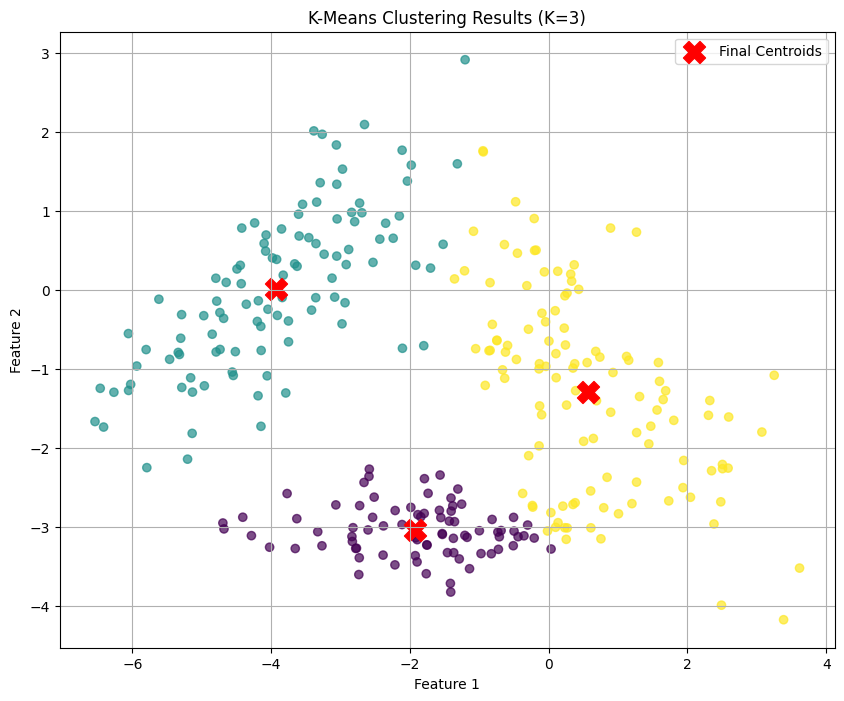

Final K-Means Centroids:
 [[-1.9285638  -3.92373524  0.56115053]
 [-3.04155556  0.01309036 -1.29804366]]


In [33]:
# K-Means Clustering

c_init  = np.array([[-2.0,-4,0],[-3,1,-1]])
eps = 0.001
K = 3
c, label = kmeans(eps, K, Xmat, c_init) 

# --- Plotting the Results ---
plt.figure(figsize=(10, 8))
plt.scatter(Xmat[:, 0], Xmat[:, 1], c=label, cmap='viridis', alpha=0.7)
plt.scatter(c[0, :], c[1, :], s=250, c='red', marker='X', label='Final Centroids')
plt.title('K-Means Clustering Results (K=3)')
plt.xlabel('Feature 1'); plt.ylabel('Feature 2'); plt.legend(); plt.grid(True)
plt.show()

print("Final K-Means Centroids:\n", c)


## How does it compare?

For this well-separated dataset, the results are nearly identical. However, the underlying mechanisms differ significantly:

Assignment: K-Means performs a "hard" assignment; each data point is assigned definitively to a single cluster. EM for GMMs, on the other hand, performs a "soft" assignment; it calculates the posterior probability (responsibility) that a point belongs to each cluster, making it more suitable for overlapping data.

Cluster Shape: K-Means is fundamentally trying to minimize the within-cluster sum of squares (WCSS), which implicitly assumes that clusters are isotropic or spherical. As you noted, a GMM can model more flexible, anisotropic elliptical shapes, assuming a full covariance matrix is learned for each component.